In [20]:
import os
import glob
from pathlib import Path
from datetime import datetime

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TrainingConfig:
    def __init__(self):
        self.batch_size = 32
        self.learning_rate = 2e-4
        self.num_epochs = 10
        self.save_every = 10
        self.frames_dir = "frames"
        self.white_weight = 4.0  # upweight white pixels
        self.num_workers = 0
        self.pin_memory = torch.cuda.is_available()

config = TrainingConfig()
print(f"Device: {device}")

Device: cuda


In [21]:
class PongSequenceDataset(Dataset):
    def __init__(self, frames_dir="frames", sequence_length=3):
        self.frames_dir = Path(frames_dir)
        self.sequence_length = sequence_length
        self.frame_files = sorted([f for f in self.frames_dir.glob("*.png")])
        self.sequences = self._group_sequences()

        print(f"Found {len(self.frame_files)} frames")
        print(f"Sequences: {len(self.sequences)}")

    def _group_sequences(self):
        sequences, session, prefix = [], [], None
        for f in self.frame_files:
            parts = f.stem.split('_')
            if len(parts) >= 3:
                p = '_'.join(parts[:-1])
                if prefix is None or p == prefix:
                    session.append(f); prefix = p
                else:
                    if len(session) >= self.sequence_length:
                        for i in range(len(session) - self.sequence_length + 1):
                            sequences.append(session[i:i+self.sequence_length])
                    session, prefix = [f], p
        if len(session) >= self.sequence_length:
            for i in range(len(session) - self.sequence_length + 1):
                sequences.append(session[i:i+self.sequence_length])
        return sequences

    def __len__(self): return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        frames = []
        for f in seq:
            img = Image.open(f).convert("L")
            arr = np.array(img, dtype=np.float32) / 255.0
            frames.append(torch.from_numpy(arr).unsqueeze(0))  # [1, H, W]
        prev_, curr_, target = frames[0], frames[1], frames[2]
        inp = torch.cat([prev_, curr_], dim=0)  # [2, H, W]
        return inp, target

# Build loaders
train_ds = PongSequenceDataset(config.frames_dir, sequence_length=3)
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True,
                          num_workers=config.num_workers, pin_memory=config.pin_memory)

x, y = next(iter(train_loader))
print(f"Batch shapes: input {x.shape} (B,2,200,200), target {y.shape} (B,1,200,200)")

Found 6496 frames
Sequences: 6494
Batch shapes: input torch.Size([32, 2, 200, 200]) (B,2,200,200), target torch.Size([32, 1, 200, 200]) (B,1,200,200)


In [22]:
class PatchEmbed(nn.Module):
    def __init__(self, in_ch=2, embed_dim=384, patch_size=10, img_size=200):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.grid = img_size // patch_size
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos = nn.Parameter(torch.zeros(1, self.grid*self.grid, embed_dim))  # learned pos

    def forward(self, x):
        # x: [B,2,200,200]
        x = self.proj(x)              # [B, C, 20, 20]
        x = x.flatten(2).transpose(1, 2)  # [B, 400, C]
        x = x + self.pos
        return x  # tokens

class ViTNextFrame(nn.Module):
    """
    Vision Transformer next-frame predictor
    - Input: two frames [t-1, t] in [0,1]
    - Output: t+1 via residual added to latest frame
    """
    def __init__(self, img_size=200, patch_size=10, in_chans=2,
                 embed_dim=384, depth=6, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.patch = PatchEmbed(in_chans, embed_dim, patch_size, img_size)
        self.grid = img_size // patch_size
        self.embed_dim = embed_dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=int(embed_dim*mlp_ratio),
                                                   batch_first=True, norm_first=True, dropout=0.0)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # control conditioning from bottom row of latest frame (200 dims -> embed_dim)
        self.ctrl_mlp = nn.Sequential(
            nn.Linear(200, 128), nn.ReLU(),
            nn.Linear(128, embed_dim), nn.ReLU()
        )

        # token to patch-pixels
        self.head = nn.Linear(embed_dim, patch_size*patch_size)

        self.patch_size = patch_size
        self.img_size = img_size

    def unpatchify(self, tokens):
        # tokens: [B, N=400, P*P] -> [B, 1, 200, 200]
        B, N, PP = tokens.shape
        P = self.patch_size
        G = self.grid
        x = tokens.view(B, G, G, P, P)      # [B, 20,20,10,10]
        x = x.permute(0,1,3,2,4).contiguous().view(B, 1, G*P, G*P)
        return x

    def forward(self, two_frames):
        # two_frames: [B,2,200,200], in [0,1]
        B = two_frames.size(0)
        latest = two_frames[:, 1:2]  # [B,1,200,200]

        # control conditioning from bottom row of latest frame
        bottom = latest[:, 0, -1, :]         # [B,200]
        ctrl_vec = self.ctrl_mlp(bottom)     # [B,embed_dim]

        tokens = self.patch(two_frames)      # [B,400,embed_dim]
        # add control bias to every token
        tokens = tokens + ctrl_vec.unsqueeze(1)

        tokens = self.encoder(tokens)        # [B,400,embed_dim]
        pix = self.head(tokens)              # [B,400, P*P]
        residual = torch.tanh(pix)           # [-1,1] per pixel
        residual_img = self.unpatchify(residual)  # [B,1,200,200]
        out = torch.clamp(latest + residual_img, 0.0, 1.0)
        return out

# Build model
model = ViTNextFrame().to(device)
print("Model params:", sum(p.numel() for p in model.parameters())/1e6, "M")

Model params: 10.991332 M


c:\Users\Zachary\Desktop\Development\GenerativePhysics\Pong\venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [23]:
def weighted_l1_loss(pred: torch.Tensor, tgt: torch.Tensor, white_weight: float = 4.0):
    # Upweight bright pixels; includes bottom row
    w = 1.0 + white_weight * tgt
    return torch.mean(w * torch.abs(pred - tgt))

@torch.inference_mode()
def visualize_batch(model, loader, max_cols=4):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(device); y = y.to(device)
    yhat = model(x)

    x = x.cpu(); y = y.cpu(); yhat = yhat.cpu()
    cols = min(max_cols, x.shape[0])
    fig, axes = plt.subplots(3, cols, figsize=(4*cols, 9))
    if cols == 1: axes = axes.reshape(3,1)
    for i in range(cols):
        axes[0,i].imshow(x[i,1], cmap="gray", vmin=0, vmax=1); axes[0,i].set_title("Input t"); axes[0,i].axis('off')
        axes[1,i].imshow(y[i,0], cmap="gray", vmin=0, vmax=1); axes[1,i].set_title("Target t+1"); axes[1,i].axis('off')
        axes[2,i].imshow(yhat[i,0], cmap="gray", vmin=0, vmax=1); axes[2,i].set_title("Pred"); axes[2,i].axis('off')
    plt.tight_layout(); plt.show()

def train(model, loader, cfg: TrainingConfig):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate, betas=(0.9, 0.95), weight_decay=0.01)
    model.train()
    for epoch in range(cfg.num_epochs):
        running = 0.0
        for i, (x,y) in enumerate(loader):
            x = x.to(device); y = y.to(device)
            opt.zero_grad()
            yhat = model(x)
            loss = weighted_l1_loss(yhat, y, cfg.white_weight)
            loss.backward()
            opt.step()
            running += loss.item()
            if i % 20 == 0:
                print(f"Epoch {epoch+1}/{cfg.num_epochs} | Batch {i}/{len(loader)} | Loss {loss.item():.4f}")
        print(f"Epoch {epoch+1} avg loss: {running/len(loader):.4f}")

        if (epoch + 1) % cfg.save_every == 0:
            torch.save(model.state_dict(), f"pong_vit_epoch_{epoch+1}.pth")
            print(f"Saved: pong_vit_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), "pong_vit_final.pth")
    print("Saved final: pong_vit_final.pth")

print("Ready: call train(model, train_loader, config)")

Ready: call train(model, train_loader, config)


In [24]:
class ViTInference:
    def __init__(self, model: ViTNextFrame, model_path: str|None = None):
        self.model = model.to(device).eval()
        if model_path and Path(model_path).exists():
            try:
                state = torch.load(model_path, map_location=device)
                # raw state_dict or checkpoint dict support
                if isinstance(state, dict) and "model_state_dict" in state:
                    self.model.load_state_dict(state["model_state_dict"])
                else:
                    self.model.load_state_dict(state)
                print(f"Loaded model: {model_path}")
            except Exception as e:
                print(f"Could not load model ({model_path}): {e}")

        # warmup
        with torch.inference_mode():
            for _ in range(20):
                _ = self.model(torch.rand(1,2,200,200, device=device))

    @torch.inference_mode()
    def predict_next(self, prev_np: np.ndarray, curr_np: np.ndarray):
        prev_t = torch.from_numpy(prev_np.astype(np.float32)/255.0).unsqueeze(0).unsqueeze(0)
        curr_t = torch.from_numpy(curr_np.astype(np.float32)/255.0).unsqueeze(0).unsqueeze(0)
        x = torch.cat([prev_t, curr_t], dim=1).to(device)
        yhat = self.model(x)[0,0].clamp(0,1).cpu().numpy()
        return (yhat * 255.0).astype(np.uint8)

def find_model_path(default="pong_vit_final.pth"):
    p = Path(default)
    if p.exists(): return str(p)
    cks = sorted(glob.glob("pong_vit_epoch_*.pth"))
    return cks[-1] if cks else None

def get_seed(frames_dir="frames"):
    if os.path.isdir(frames_dir):
        pngs = sorted([p for p in os.listdir(frames_dir) if p.endswith(".png")])
        if pngs:
            img = Image.open(os.path.join(frames_dir, pngs[0])).convert("L")
            return np.array(img, dtype=np.uint8)
    # fallback synthetic
    fr = np.zeros((200,200), dtype=np.uint8)
    fr[82:118, 10:16] = 255; fr[82:118, 184:190] = 255; fr[97:103, 97:103] = 255; fr[-1,:] = 0
    return fr

def generate_gameplay_vit(num_frames=1200, fps=60, output_dir=None, model_path=None, save_video=True):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    outdir = Path(output_dir) if output_dir else Path(f"generated_vit_{ts}")
    outdir.mkdir(parents=True, exist_ok=True)

    model_path = model_path or find_model_path()
    engine = ViTInference(ViTNextFrame(), model_path)

    prev = get_seed()
    curr = prev.copy()

    writer = None
    if save_video:
        try:
            import imageio
            writer = imageio.get_writer(outdir / "gameplay.mp4", fps=fps)
        except Exception as e:
            print(f"Video disabled ({e}). Install with: pip install imageio[ffmpeg]")

    print(f"Generating {num_frames} frames to {outdir}")
    
    # Save and include the seed frame in video
    Image.fromarray(curr).save(outdir / f"frame_{0:05d}.png")
    if writer: writer.append_data(curr)
    
    for i in range(num_frames):
        nxt = engine.predict_next(prev, curr)
        Image.fromarray(nxt).save(outdir / f"frame_{i+1:05d}.png")
        if writer: writer.append_data(nxt)
        prev, curr = curr, nxt
        if (i+1) % 100 == 0: print(f"{i+1}/{num_frames}")

    if writer: writer.close()
    print("Done.")
    return str(outdir)

Epoch 1/10 | Batch 0/203 | Loss 0.3315
Epoch 1/10 | Batch 20/203 | Loss 0.0541
Epoch 1/10 | Batch 40/203 | Loss 0.0536
Epoch 1/10 | Batch 60/203 | Loss 0.0473
Epoch 1/10 | Batch 80/203 | Loss 0.0428
Epoch 1/10 | Batch 100/203 | Loss 0.0253
Epoch 1/10 | Batch 120/203 | Loss 0.0136
Epoch 1/10 | Batch 140/203 | Loss 0.0112
Epoch 1/10 | Batch 160/203 | Loss 0.0113
Epoch 1/10 | Batch 180/203 | Loss 0.0085
Epoch 1/10 | Batch 200/203 | Loss 0.0076
Epoch 1 avg loss: 0.0326
Epoch 2/10 | Batch 0/203 | Loss 0.0073
Epoch 2/10 | Batch 20/203 | Loss 0.0069
Epoch 2/10 | Batch 40/203 | Loss 0.0070
Epoch 2/10 | Batch 60/203 | Loss 0.0049
Epoch 2/10 | Batch 80/203 | Loss 0.0056
Epoch 2/10 | Batch 100/203 | Loss 0.0076
Epoch 2/10 | Batch 120/203 | Loss 0.0048
Epoch 2/10 | Batch 140/203 | Loss 0.0046
Epoch 2/10 | Batch 160/203 | Loss 0.0038
Epoch 2/10 | Batch 180/203 | Loss 0.0057
Epoch 2/10 | Batch 200/203 | Loss 0.0043
Epoch 2 avg loss: 0.0056
Epoch 3/10 | Batch 0/203 | Loss 0.0056
Epoch 3/10 | Batch 20

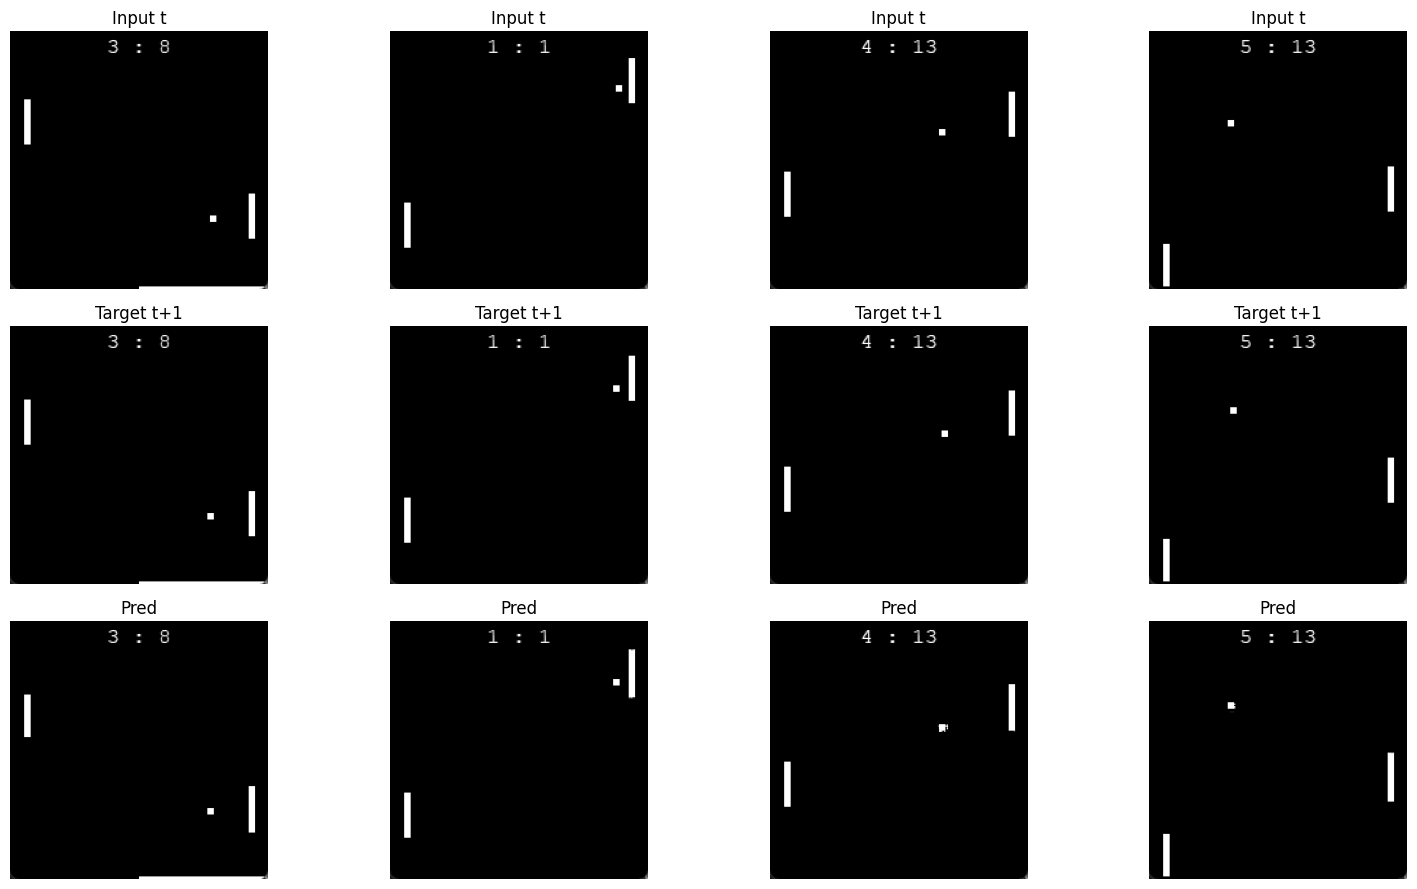

In [25]:
# Train:
train(model, train_loader, config)

# Visual check:
visualize_batch(model, train_loader)


In [26]:
out_dir = generate_gameplay_vit(num_frames=1800, fps=60, model_path="pong_vit_final.pth")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Loaded model: pong_vit_final.pth
Generating 1800 frames to generated_vit_20250809_005220
100/1800
200/1800
300/1800
400/1800
500/1800
600/1800
700/1800
800/1800
900/1800
1000/1800
1100/1800
1200/1800
1300/1800
1400/1800
1500/1800
1600/1800
1700/1800
1800/1800
Done.
